In [100]:
# Setup
import numbers
import os
from typing import Tuple, TypeVar, Union, Optional, Callable
import math

import matplotlib.pyplot as plt
import pandas as pd
import pyro.distributions as dist
from pyro.distributions import constraints
import seaborn as sns
import torch
from pyro.infer import Predictive

import pyro
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.dynamical.handlers.interruption import StaticEvent
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.ops import Dynamics, State, on, simulate
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.ops import Intervention, intervene
from chirho.observational.handlers import condition

R = Union[numbers.Real, torch.Tensor]
S = TypeVar("S")
T = TypeVar("T")


sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_samples = 10 if smoke_test else 300
exp_plate_size = 10 if smoke_test else 2000

In [101]:
# dS = - beta . SI
# dI = beta * SI - gamma * I
# dR = gamma * I

class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX: State[torch.Tensor] = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]

        return dX


# TODO add running overshoot to states?
# beta = (1 - l) beta0

class SIRDynamicsLockdown(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(X["l"])
        return dX

In [102]:
# Computing overshoot in a simple SIR model

init_state = dict(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(12.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)
init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

# We now simulate from the SIR model
beta_true = torch.tensor([0.03])
gamma_true = torch.tensor([0.5])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory


def get_overshoot(trajectory):
    t_max = torch.argmax(trajectory["I"].squeeze())
    S_peak = torch.max(trajectory["S"].squeeze()[t_max]) / 100
    S_final = trajectory["S"].squeeze()[-1] / 100
    return (S_peak - S_final).item()


print(get_overshoot(sir_true_traj))

0.15116800367832184


In [103]:
# Defining a Bayesian SIR model where we have priors over beta and gamma distributions

def bayesian_sir(base_model=SIRDynamics) -> Dynamics[torch.Tensor]:
    beta = pyro.sample("beta", dist.Beta(18, 600))
    gamma = pyro.sample("gamma", dist.Beta(1600, 1600))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(
    init_state, start_time, logging_times, base_model=SIRDynamics
) -> State[torch.Tensor]:
    sir = bayesian_sir(base_model)

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [104]:
# Defining intervention

def MaskedStaticIntervention(time: R, intervention: Intervention[State[T]]):

    @on(StaticEvent(time))
    def callback(
        dynamics: Dynamics[T], state: State[T]
    ) -> Tuple[Dynamics[T], State[T]]:

        with pyro.poutine.block():
            return dynamics, intervene(state, intervention)

    return callback

In [105]:
# Defining the policy model

overshoot_threshold = 20
lockdown_time = torch.tensor(1.0)
mask_time = torch.tensor(1.5)


def policy_model():

    lockdown = pyro.sample("lockdown", dist.Bernoulli(torch.tensor(0.5)))
    mask = pyro.sample("mask", dist.Bernoulli(torch.tensor(0.5)))

    lockdown_efficiency = pyro.deterministic(
        "lockdown_efficiency", torch.tensor(0.6) * lockdown, event_dim=0
    )

    mask_efficiency = pyro.deterministic(
        "mask_efficiency", (0.1 * lockdown + 0.45 * (1 - lockdown)) * mask, event_dim=0
    )

    joint_efficiency = pyro.deterministic(
        "joint_efficiency",
        torch.clamp(lockdown_efficiency + mask_efficiency, 0, 0.95),
        event_dim=0,
    )

    lockdown_sir = bayesian_sir(SIRDynamicsLockdown)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with MaskedStaticIntervention(lockdown_time, dict(l=lockdown_efficiency)):
                with MaskedStaticIntervention(mask_time, dict(l=joint_efficiency)):
                    simulate(
                        lockdown_sir, init_state_lockdown, start_time, logging_times[-1]
                    )

    trajectory = lt.trajectory

    t_max = torch.max(trajectory["I"], dim=-1).indices
    S_peaks = pyro.ops.indexing.Vindex(trajectory["S"])[..., t_max]
    overshoot = pyro.deterministic(
        "overshoot", S_peaks - trajectory["S"][..., -1], event_dim=0
    )
    os_too_high = pyro.deterministic(
        "os_too_high",
        (overshoot > overshoot_threshold).clone().detach().float(),
        event_dim=0,
    )

    return overshoot, os_too_high

In [106]:
# conditioning (as opposed to intervening) is sufficient for
# propagating the changes, as the decisions are upstream from ds

# Doing but-for analysis

# no interventions
num_samples = 10000
policy_model_none = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)}
)
unintervened_predictive = Predictive(
    policy_model_none, num_samples=num_samples, parallel=True
)
unintervened_samples = unintervened_predictive()

# both interventions
policy_model_all = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)}
)
intervened_predictive = Predictive(
    policy_model_all, num_samples=num_samples, parallel=True
)
intervened_samples = intervened_predictive()

policy_model_mask = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(1.0)}
)
mask_predictive = Predictive(policy_model_mask, num_samples=num_samples, parallel=True)
mask_samples = mask_predictive()

policy_model_lockdown = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(0.0)}
)
lockdown_predictive = Predictive(
    policy_model_lockdown, num_samples=num_samples, parallel=True
)
lockdown_samples = lockdown_predictive()

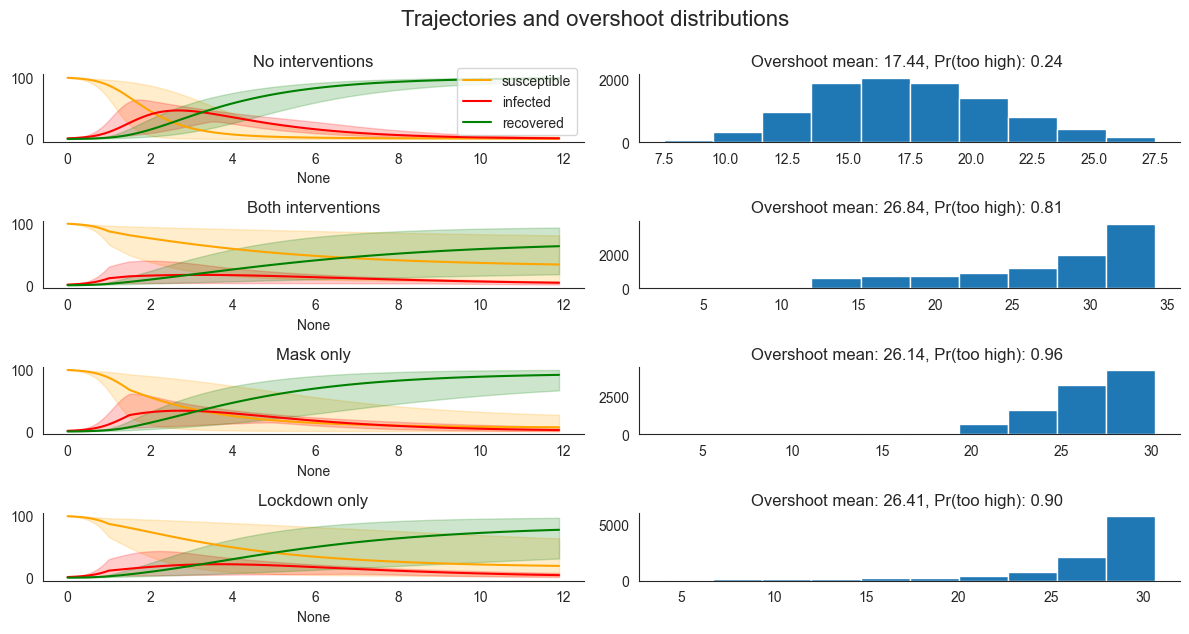

In [107]:
# Plotting them, if I do but-for analysis of mask or lockdown, they both come out to not be the cause. That is not true if I use both as the cause, so what exactly is their role and
# how can we get more fine-grained information

def add_pred_to_plot(preds, axs, coords, color, label):
    sns.lineplot(
        x=logging_times,
        y=preds.mean(dim=0).squeeze().tolist(),
        ax=axs[coords],
        label=label,
        color=color,
    )
    axs[coords].fill_between(
        logging_times,
        torch.quantile(preds, 0.025, dim=0).squeeze(),
        torch.quantile(preds, 0.975, dim=0).squeeze(),
        alpha=0.2,
        color=color,
    )


fig, axs = plt.subplots(4, 2, figsize=(12, 6))

colors = ["orange", "red", "green"]

add_pred_to_plot(
    unintervened_samples["S"], axs, coords=(0, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    unintervened_samples["I"], axs, coords=(0, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    unintervened_samples["R"], axs, coords=(0, 0), color=colors[2], label="recovered"
)

axs[0, 1].hist(unintervened_samples["overshoot"].squeeze())
axs[0, 0].set_title("No interventions")
axs[0, 1].set_title(
    f"Overshoot mean: {unintervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {unintervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    intervened_samples["S"], axs, coords=(1, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    intervened_samples["I"], axs, coords=(1, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    intervened_samples["R"], axs, coords=(1, 0), color=colors[2], label="recovered"
)
axs[1, 0].set_title("Both interventions")
axs[1, 0].legend_.remove()


axs[1, 1].hist(intervened_samples["overshoot"].squeeze())
axs[1, 1].set_title(
    f"Overshoot mean: {intervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {intervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    mask_samples["S"], axs, coords=(2, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    mask_samples["I"], axs, coords=(2, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    mask_samples["R"], axs, coords=(2, 0), color=colors[2], label="recovered"
)
axs[2, 0].set_title("Mask only")
axs[2, 0].legend_.remove()

axs[2, 1].hist(mask_samples["overshoot"].squeeze())
axs[2, 1].set_title(
    f"Overshoot mean: {mask_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {mask_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(
    lockdown_samples["S"], axs, coords=(3, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    lockdown_samples["I"], axs, coords=(3, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    lockdown_samples["R"], axs, coords=(3, 0), color=colors[2], label="recovered"
)
axs[3, 0].set_title("Lockdown only")
axs[3, 0].legend_.remove()

axs[3, 1].hist(lockdown_samples["overshoot"].squeeze())
axs[3, 1].set_title(
    f"Overshoot mean: {lockdown_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {lockdown_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


fig.tight_layout()
fig.suptitle("Trajectories and overshoot distributions", fontsize=16, y=1.05)
sns.despine()

plt.savefig("counterfactual_sir.png")

# analysis of os_too_high using SearchForExplanation

In [151]:
with ExtractSupports() as s:
    policy_model()

supports = s.supports
supports["os_too_high"] = constraints.independent(base_constraint=constraints.boolean, reinterpreted_batch_ndims=0)

antecedents = {"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)}
alternatives = {"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)}
witnesses = {key: s.supports[key] for key in ["lockdown_efficiency", "mask_efficiency"]}
consequents = {"os_too_high": torch.tensor(1.0)}

with MultiWorldCounterfactual() as mwc_plate:
    with SearchForExplanation(
        supports=supports,
        alternatives=alternatives,
        antecedents=antecedents,
        antecedent_bias=0.0,
        witnesses=witnesses,
        consequents=consequents,
        consequent_scale=1e-8,
        witness_bias=0.2,
    ):
        with pyro.plate("sample", exp_plate_size):
            with pyro.poutine.trace() as tr:
                policy_model_all()

In [109]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc_imp:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc_imp, log_weights

    return _wrapped_model

In [129]:
query = SearchForExplanation(
            supports=supports,
            alternatives={"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)},
            antecedents={"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)},
            antecedent_bias=0.0,
            witnesses={key: s.supports[key] for key in ["lockdown_efficiency", "mask_efficiency"]},
            consequents={"os_too_high": torch.tensor(1.0)},
            consequent_scale=1e-8,
            witness_bias=0.2,
        )(policy_model_all)

logp, importance_tr, mwc_imp, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(0.0308)


In [111]:
# Computing probability of different sets of variables being the cause and degree of responsibility
trace = importance_tr
mask_intervened = (trace.nodes["__cause____antecedent_lockdown"]["value"] == 0) & (trace.nodes["__cause____antecedent_mask"]["value"] == 0)  
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum())

mask_intervened = (trace.nodes["__cause____antecedent_lockdown"]["value"] == 0) & (trace.nodes["__cause____antecedent_mask"]["value"] == 1)  
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum())

mask_intervened = (trace.nodes["__cause____antecedent_lockdown"]["value"] == 1) & (trace.nodes["__cause____antecedent_mask"]["value"] == 0)  
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum())

mask_intervened = (trace.nodes["__cause____antecedent_lockdown"]["value"] == 1) & (trace.nodes["__cause____antecedent_mask"]["value"] == 1)  
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum())

mask_intervened = (trace.nodes["__cause____antecedent_lockdown"]["value"] == 0)
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum())

mask_intervened = (trace.nodes["__cause____antecedent_mask"]["value"] == 0)
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum())

tensor(0.0488)
tensor(0.0760)
tensor(4.3182e-10)
tensor(4.8446e-10)
tensor(0.0626)
tensor(0.0241)


# Fine grained analysis of overshoot variables

## Factual plot

In [130]:
def histogram_data(trace, mwc, masks, world):
    with mwc:
        data_to_plot = gather(trace.nodes["overshoot"]["value"], IndexSet(**{"lockdown": {world}, "mask": {world}}))

        mask_tensor = torch.ones(importance_tr.nodes["__cause____antecedent_mask"]["value"].shape).bool()
        for key, val in masks.items():
            mask_tensor = mask_tensor & (trace.nodes[key]["value"] == val)
        data_to_plot = data_to_plot.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        os_too_high = (gather(trace.nodes["os_too_high"]["value"], IndexSet(**{"lockdown": {world}, "mask": {world}})))
        os_too_high = os_too_high.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        overshoot_mean = data_to_plot.mean()
        os_too_high_mean = os_too_high.mean()

    hist, bin_edges = torch.histogram(data_to_plot, bins = 28, range=(5, 40), density=True)
    return hist, bin_edges, overshoot_mean, os_too_high_mean


In [131]:
hist_fact, bin_edges, os_fact, oth_fact = histogram_data(importance_tr, mwc_imp, {}, 0)
hist_mask, bin_edges, os_mask, oth_mask = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0}, 1)
hist_lockdown, bin_edges, os_lockdown, oth_lockdown = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0}, 1)

Overshoot mean
factual:  26.768293380737305  counterfactual mask:  26.331018447875977  counterfactual lockdown:  20.962488174438477
Probability of overshoot being high
factual:  0.8101999759674072  counterfactual mask:  0.8904281854629517  counterfactual lockdown:  0.5546666383743286


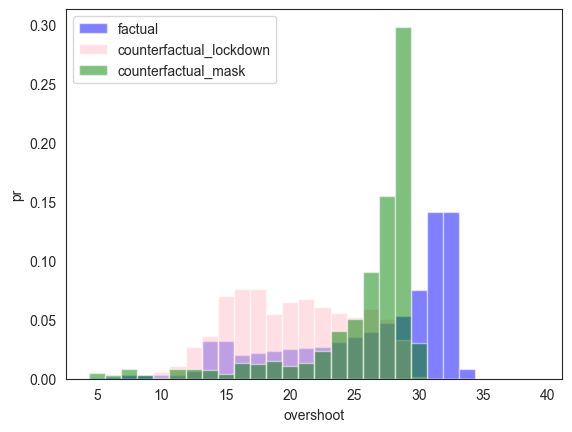

In [137]:
plt.bar(bin_edges[:28].tolist(), hist_fact, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.bar(bin_edges[:28].tolist(), hist_mask, align='center', width = 35/28, alpha = 0.5, color='green')
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")

print("Overshoot mean")
print("factual: ", os_fact.item(), " counterfactual mask: ", os_mask.item(), " counterfactual lockdown: ", os_lockdown.item())

print("Probability of overshoot being high")
print("factual: ", oth_fact.item(), " counterfactual mask: ", oth_mask.item(), " counterfactual lockdown: ", oth_lockdown.item())

# Sufficiency worlds

In [167]:
hist_fact, bin_edges, os_fact, oth_fact = histogram_data(importance_tr, mwc_imp, {}, 0)
hist_mask, bin_edges, os_mask, oth_mask = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0}, 2)
hist_lockdown, bin_edges, os_lockdown, oth_lockdown = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0}, 2)

Overshoot mean
factual:  26.768293380737305  counterfactual mask:  26.77214813232422  counterfactual lockdown:  26.866281509399414
Probability of overshoot being high
factual:  0.8101999759674072  counterfactual mask:  0.8060453534126282  counterfactual lockdown:  0.8146666884422302


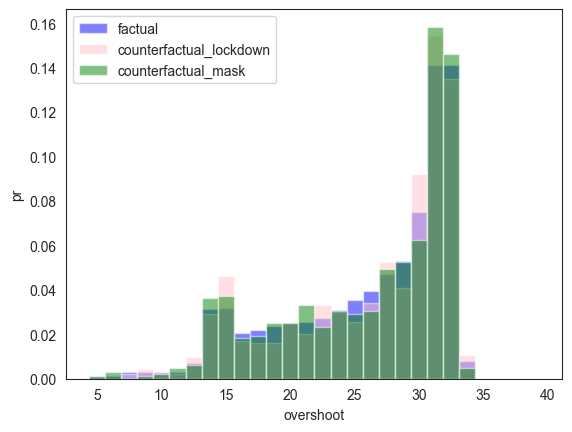

In [168]:
plt.bar(bin_edges[:28].tolist(), hist_fact, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.bar(bin_edges[:28].tolist(), hist_mask, align='center', width = 35/28, alpha = 0.5, color='green')
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")

print("Overshoot mean")
print("factual: ", os_fact.item(), " counterfactual mask: ", os_mask.item(), " counterfactual lockdown: ", os_lockdown.item())

print("Probability of overshoot being high")
print("factual: ", oth_fact.item(), " counterfactual mask: ", oth_mask.item(), " counterfactual lockdown: ", oth_lockdown.item())

# Counterfactual lockdown by mask efficiency contexts

In [169]:
hist_lockdown_fix, bin_edges, os_lockdown_fix, oth_lockdown_fix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0, "__cause____witness_mask_efficiency": 1}, 1)
hist_lockdown_notfix, bin_edges, os_lockdown_notfix, oth_lockdown_notfix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0, "__cause____witness_mask_efficiency": 0}, 1)

Overshoot mean
mask_efficiency fixed:  18.921985626220703  mask_efficiency not fixed:  26.140743255615234
Probability of overshoot being high
mask_efficiency fixed:  0.38847583532333374  mask_efficiency not fixed:  0.9764150977134705


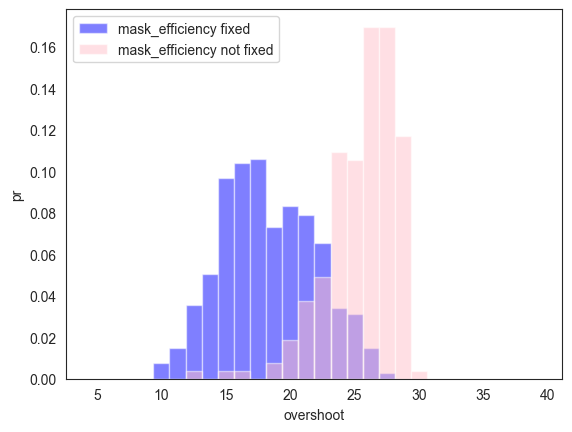

In [178]:
plt.bar(bin_edges[:28].tolist(), hist_lockdown_fix, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown_notfix, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.legend(["mask_efficiency fixed", "mask_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")

print("Overshoot mean")
print("mask_efficiency fixed: ", os_lockdown_fix.item(), " mask_efficiency not fixed: ", os_lockdown_notfix.item())

print("Probability of overshoot being high")
print("mask_efficiency fixed: ", oth_lockdown_fix.item(), " mask_efficiency not fixed: ", oth_lockdown_notfix.item())

# Counterfactual mask by lockdown efficiency contexts

In [176]:
hist_mask_fix, bin_edges, os_mask_fix, oth_mask_fix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0, "__cause____witness_lockdown_efficiency": 1}, 1)
hist_mask_notfix, bin_edges, os_mask_notfix, oth_mask_notfix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0, "__cause____witness_lockdown_efficiency": 0}, 1)

Overshoot mean
lockdown_efficiency fixed:  26.283220291137695  lockdown_efficiency not fixed:  26.437496185302734
Probability of overshoot being high
lockdown_efficiency fixed:  0.8850364685058594  lockdown_efficiency not fixed:  0.9024389982223511


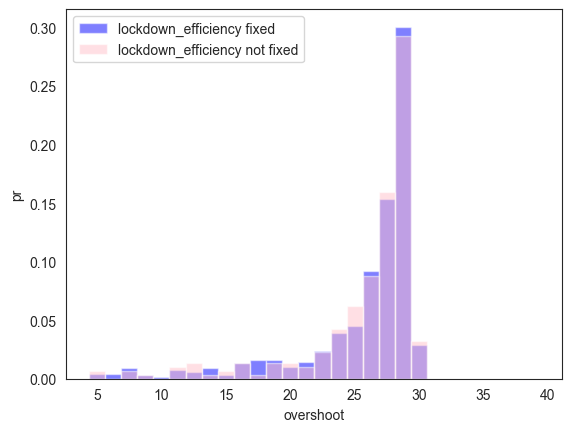

In [179]:
plt.bar(bin_edges[:28].tolist(), hist_mask_fix, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_mask_notfix, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.legend(["lockdown_efficiency fixed", "lockdown_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")

print("Overshoot mean")
print("lockdown_efficiency fixed: ", os_mask_fix.item(), " lockdown_efficiency not fixed: ", os_mask_notfix.item())

print("Probability of overshoot being high")
print("lockdown_efficiency fixed: ", oth_mask_fix.item(), " lockdown_efficiency not fixed: ", oth_mask_notfix.item())